In [1]:
import json
import os
import pandas as pd

import math


In [2]:
#open file

fileList = os.listdir("data")

#fileList
f = open("data/"+"ESZ06.json")

data = json.load(f)

In [3]:
#Can't read pandas directly, unstrucutred messed of a file
#pdData = pd.read_json("data/"+fileList[0])

In [4]:
type(data.keys())

a = set([1,2,3])

In [5]:
sample = data["data"]
dfKeys = set(sample[0].keys()).difference({"raw"})
#Maybe don't set-ify an ordered collenction
df = pd.DataFrame(sample, columns=list(dfKeys))

In [6]:
df

,lastPrice,priceChange,lowPrice,highPrice,openPrice,tradeTime,volume,openInterest,percentChange
0,"1,428.74",+2.74,"1,425.25","1,432.75","1,426.00",12/15/2006,0,0,+0.19%
1,"1,426.00",+11.75,"1,412.00","1,427.50","1,414.00",12/14/2006,"216,489","944,337",+0.83%
2,"1,414.25",+1.50,"1,410.75","1,418.50","1,413.00",12/13/2006,"219,370","974,110",+0.11%
3,"1,412.75",-1.75,"1,405.00","1,414.75","1,414.75",12/12/2006,"333,953","1,142,457",-0.12%
4,"1,414.50",+4.50,"1,409.50","1,417.00","1,409.75",12/11/2006,"294,738","1,222,469",+0.32%
...,...,...,...,...,...,...,...,...,...
59,"1,326.00",-4.25,"1,321.00","1,331.50","1,330.00",09/22/2006,"892,984","1,346,924",-0.32%
60,"1,330.25",-6.25,"1,325.50","1,340.00","1,336.50",09/21/2006,"1,248,340","1,352,953",-0.47%
61,"1,336.50",+6.00,"1,329.50","1,339.75","1,330.75",09/20/2006,"970,246","1,324,711",+0.45%
62,"1,330.50",-3.75,"1,322.75","1,334.50","1,333.75",09/19/2006,"1,176,450","1,303,729",-0.28%


In [7]:
#Lazy conversion on my end, could've used locales
#str -> specify non total item replacement
df["lastPrice"] = df["lastPrice"].str.replace(",","").astype("float64")
df["tradeTime"] = df["tradeTime"].apply(pd.to_datetime)

In [8]:
df.dtypes

lastPrice               float64
priceChange              object
lowPrice                 object
highPrice                object
openPrice                object
tradeTime        datetime64[ns]
volume                   object
openInterest             object
percentChange            object
dtype: object

In [9]:
import seaborn

In [10]:
#sample = [(x["tradeTime"],x["lastPrice"]) for x in data["data"]]

Text(0, 0.5, 'Last Price')

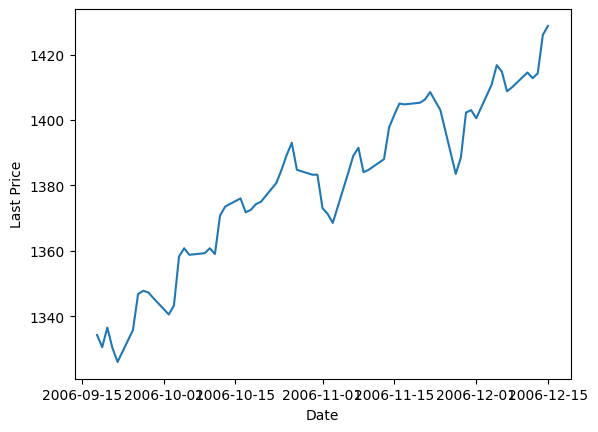

In [11]:
ss = seaborn.lineplot(x="tradeTime", y="lastPrice", data=df)
ss.set_xlabel("Date")
ss.set_ylabel("Last Price")

In [12]:
max(df["tradeTime"])-min(df["tradeTime"])

Timedelta('88 days 00:00:00')

In [13]:
logRets = (df["lastPrice"].shift(1)/df["lastPrice"]).apply(math.log) #Indexes kept

In [14]:
#Add to 
df["logReturns"] = logRets
#Indexes are kept throughout series!
df = df.drop(0) #drop the first entry for simplicity

<Axes: xlabel='tradeTime', ylabel='logReturns'>

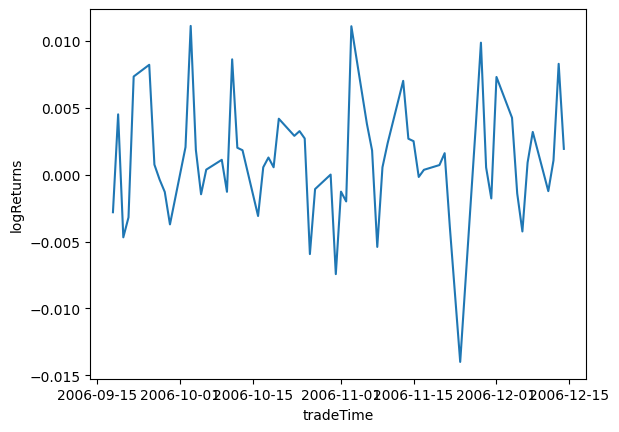

In [15]:
seaborn.lineplot(x="tradeTime", y="logReturns", data=df)

(array([ 1.,  0.,  1.,  4.,  8., 19., 16.,  5.,  5.,  4.]),
 array([-0.01399628, -0.01148615, -0.00897601, -0.00646588, -0.00395575,
        -0.00144561,  0.00106452,  0.00357465,  0.00608479,  0.00859492,
         0.01110506]),
 <BarContainer object of 10 artists>)

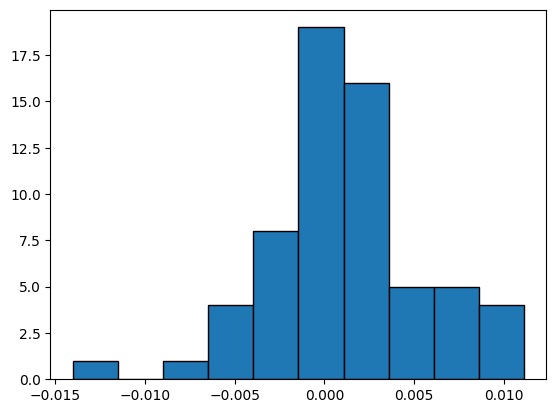

In [16]:
import matplotlib.pyplot as plt
plt.hist(df["logReturns"], edgecolor='black')

In [17]:
import statsmodels.api as sm

In [18]:
#Setup dist
import scipy.stats

#Assuming daily returns, ignoring weekends and bank holidays
bmStdDev = df["logReturns"].std()
bMotion = scipy.stats.norm(loc=0, scale=bmStdDev)

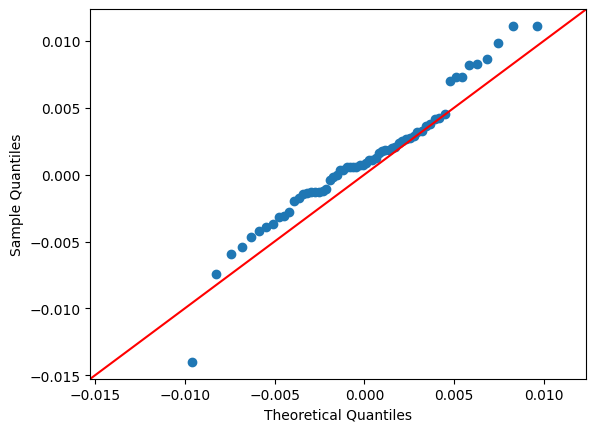

In [19]:
fig = sm.qqplot(df["logReturns"][1:], dist=bMotion, line='45')

In [20]:
#Null Hyp: The underlying dist is normal
scipy.stats.shapiro(df["logReturns"])

ShapiroResult(statistic=0.9636398279262726, pvalue=0.05969879589227293)

In [21]:
df["logReturns"][1:]

2     0.008274
3     0.001061
4    -0.001238
5     0.003186
6     0.000887
        ...   
59    0.007326
60   -0.003200
61   -0.004687
62    0.004499
63   -0.002815
Name: logReturns, Length: 62, dtype: float64

## Normality testing

In [22]:
def getReturnsDF(str):
    with open("data/"+str) as f:
        data = json.load(f)

    sample = data["data"]
    dfKeys = set(sample[0].keys()).difference({"raw"})
    #Maybe don't set-ify an ordered collenction
    df = pd.DataFrame(sample, columns=list(dfKeys))

    df["lastPrice"] = df["lastPrice"].str.replace(",","").astype("float64")
    df["tradeTime"] = df["tradeTime"].apply(pd.to_datetime)

    logRets = (df["lastPrice"].shift(1)/df["lastPrice"]).apply(math.log) #Indexes kept
    df["logReturns"] = logRets
    #Indexes are kept throughout series!
    df = df.drop(0) #drop the first entry for simplicity
    return df

In [23]:
def logRet_shapiroTest(str):

    df = getReturnsDF(str)

    bmStdDev = df["logReturns"].std()
    retMean = df["logReturns"].mean()
    bMotion = scipy.stats.norm(loc=retMean, scale=bmStdDev)

    #Null Hyp: The underlying dist is normal
    return scipy.stats.shapiro(df["logReturns"]).pvalue


In [24]:
logRet_shapiroTest(fileList[0])

0.42849579415746947

In [25]:
fileList[0]

'ESH00.json'

In [26]:
testResults = [(x, logRet_shapiroTest(x)) for x in os.listdir("data")]

In [27]:
import re

In [28]:
testResults.sort(key = lambda xs: re.sub("^([a-zA-Z]+)([0-9]+)", "\\2\\1", xs[0])) #Python's RE's are annoyingly close to vims

In [29]:
#Manual resize, could probably use filters or index searches
testResults = testResults[91:] + testResults[:91] 

In [30]:
infractors = [x for (x,p) in testResults if p < 0.1]
len(infractors)

41

<Axes: xlabel=' ', ylabel='P-value Shapiro > 0.1'>

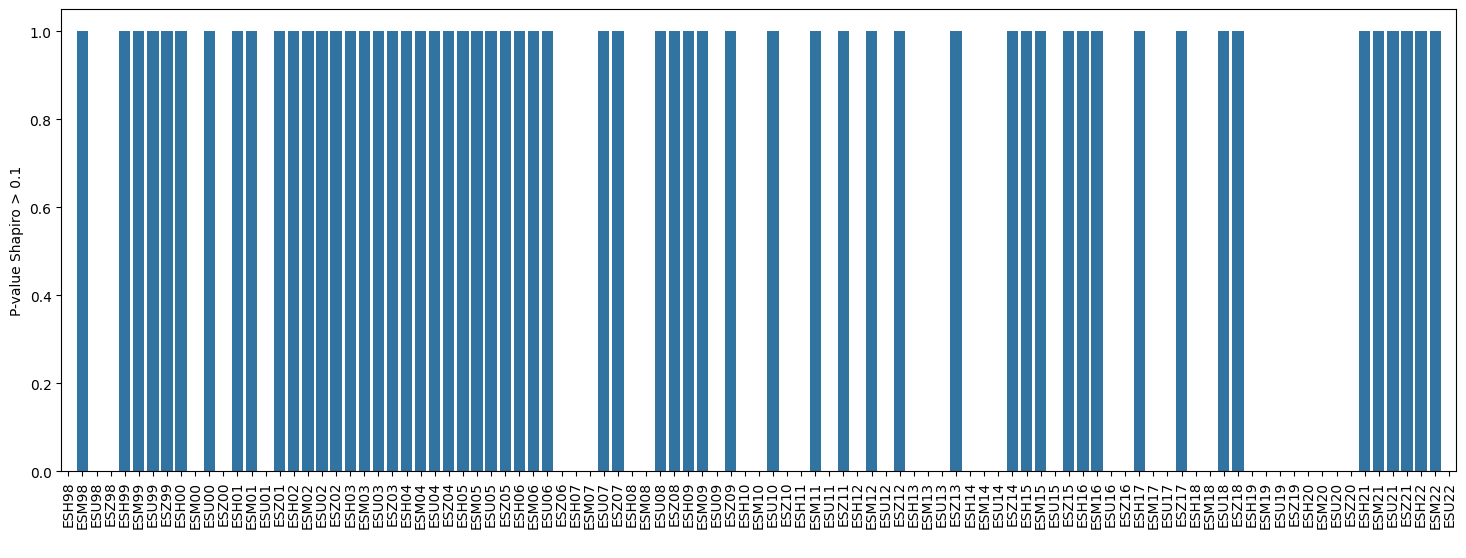

In [73]:
passes = pd.DataFrame([(re.sub(".json", "",x) ,1*(p>0.1)) for (x,p) in testResults], columns=["0","1"])

fig, ax = plt.subplots(figsize=(18, 6))
ax.tick_params(axis='x', labelrotation=90)

ax.set_ylabel("P-value Shapiro > 0.1")
ax.set_xlabel(" ")

seaborn.barplot(x="0", y="1", data=passes)


In [74]:
fig.savefig("../norm.eps",  bbox_inches="tight")

In [33]:
#Get Means
#Should I have cached the DFs? I'm not used to using notebooks
#already sorted in test results

retMeans = [(x, getReturnsDF(x)["logReturns"].mean()) for (x,_) in testResults]

#Wait I don't think he assumed anything for returns...



<Axes: xlabel='0', ylabel='Média retorno diário'>

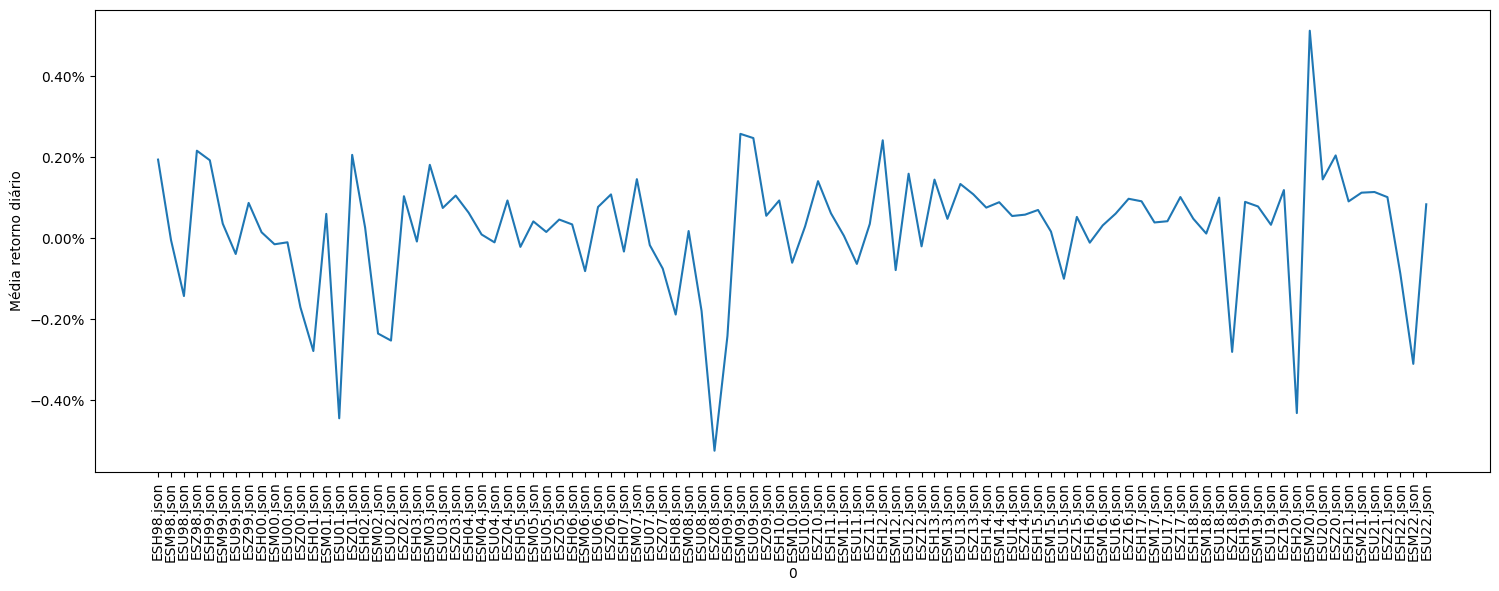

In [34]:
import matplotlib.ticker as mtick
fmt = '{x:.2%}'


fig, ax = plt.subplots(figsize=(18, 6))
fig.gca().yaxis.set_major_formatter(mtick.StrMethodFormatter(fmt))
ax.tick_params(axis='x', labelrotation=90)
ax.set_ylabel("Média retorno diário")
seaborn.lineplot(x=0, y=1, data=pd.DataFrame(retMeans))



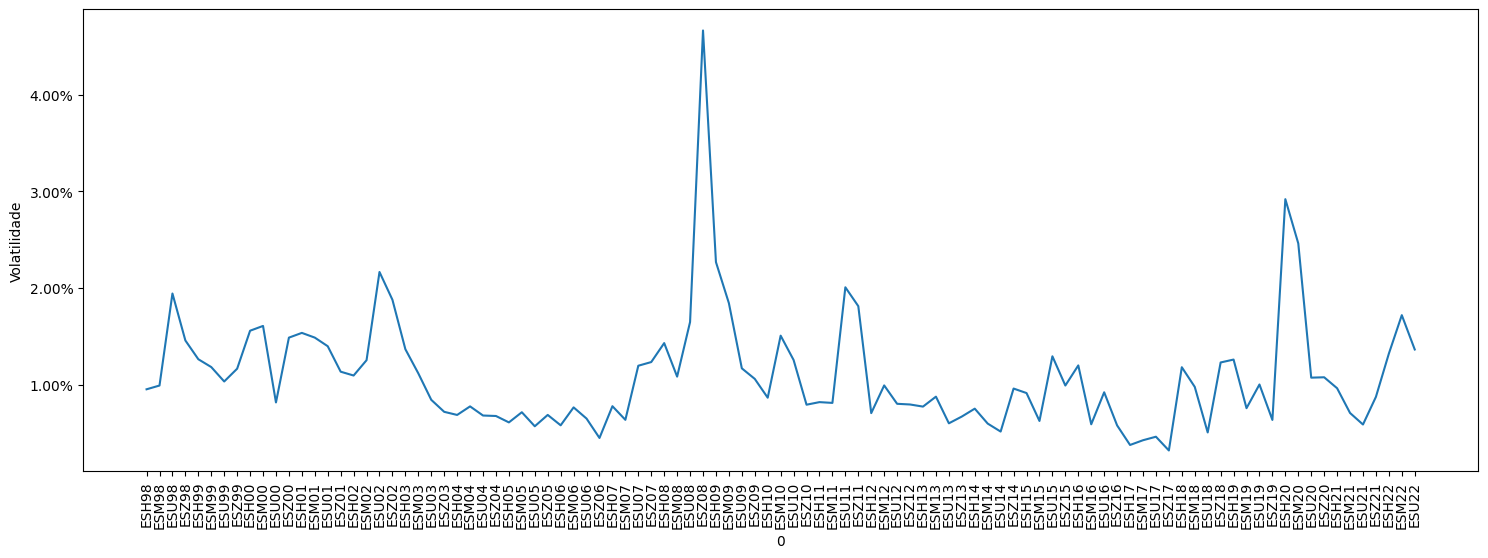

In [35]:
fig, ax = plt.subplots(figsize=(18, 6))
fig.gca().yaxis.set_major_formatter(mtick.StrMethodFormatter(fmt))
ax.tick_params(axis='x', labelrotation=90)
ax.set_ylabel("Volatilidade")
seaborn.lineplot(x=0, y=1, data=pd.DataFrame(
    [(re.sub(".json","",x), getReturnsDF(x)["logReturns"].std()) for (x,_) in testResults]
        )
                )

fig.savefig("../volatility.eps")

In [36]:
dfT = getReturnsDF(fileList[3])
dfT

,lastPrice,priceChange,lowPrice,highPrice,openPrice,tradeTime,volume,openInterest,percentChange,logReturns
1,875.75,+2.25,858.25,880.00,873.25,2003-03-20,"24,984","211,213",+0.26%,0.012945
2,873.50,+6.25,861.00,875.50,867.75,2003-03-19,"30,850","235,796",+0.72%,0.002573
3,867.25,+5.25,857.25,873.75,862.50,2003-03-18,"43,349","254,028",+0.61%,0.007181
4,862.00,+27.75,823.50,864.00,831.50,2003-03-17,"49,994","262,611",+3.33%,0.006072
5,834.25,+1.00,828.00,843.50,833.00,2003-03-14,"59,767","285,992",+0.12%,0.032722
...,...,...,...,...,...,...,...,...,...,...
59,891.50,-5.50,891.25,900.00,897.00,2002-12-24,"95,319","169,316",-0.61%,-0.000842
60,897.00,+0.25,890.25,902.00,896.25,2002-12-23,"247,476","166,561",+0.03%,-0.006150
61,896.75,+12.00,884.25,897.25,884.50,2002-12-20,"361,821","158,882",+1.36%,0.000279
62,884.75,-6.75,878.75,900.25,892.00,2002-12-19,"543,007","125,222",-0.76%,0.013472


<Axes: xlabel='tradeTime', ylabel='logReturns'>

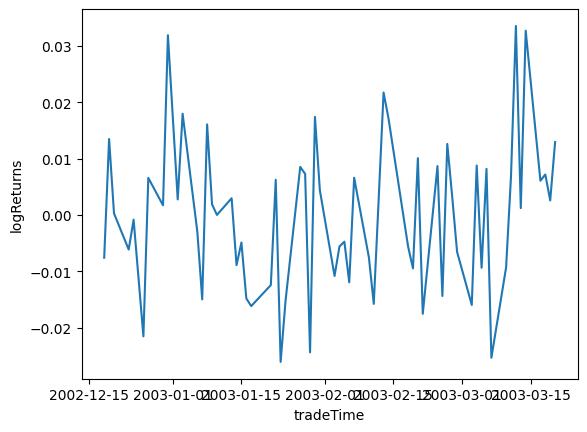

In [37]:
seaborn.lineplot(x="tradeTime", y="logReturns", data=dfT)

# Constant variance testing

Comparing the first half of the data with the second half

### Delta analysis

In [38]:
#Going to use stored dfs, makes more sense then reloading them from an str
def volatilityDelta(df):
    if "logReturns" not in df.columns:
        raise ValueError("Missing log returns") #pretty sure it wouldve called out on its own. Eh wtv
    #ilocs are preserving date orders as far as I know
    h = len(df)//2
    #i want
    #df[:h] and df[h:]...
    #This is WAAAY to complicated but I HATE rewriting something
    stdDevs = [df.iloc[a:b]["logReturns"].std() for (a,b) in [(None,h),(h,None)]]
    #I'd probably want to do matrix mult here fyi
    return stdDevs[1] - stdDevs[0]
    

In [63]:
def flignerDFs(df):
    if "logReturns" not in df.columns:
        raise ValueError("Missing log returns") #pretty sure it wouldve called out on its own. Eh wtv
    h = len(df)//2
    test = scipy.stats.fligner(*(df.iloc[a:b]["logReturns"] for (a,b) in [(None,h),(h,None)]))
    return test.pvalue


In [39]:
dframes = [(re.sub("\\.json", "",x),
            getReturnsDF(x)) for x in os.listdir("data")]

In [40]:


#Manual resize

dframes.sort(key = lambda xs: re.sub("^([a-zA-Z]+)([0-9]+)", "\\2\\1", xs[0]))
dframes = dframes[91:] + dframes[:91]

#Yes I just realized I couldve done for (a,b) in _
vols = pd.DataFrame([(xs[0], xs[1]["logReturns"].std()) for xs in dframes], columns=["0", "Vol"])

volDeltas = pd.DataFrame([(xs[0], volatilityDelta(xs[1])) for xs in dframes], columns=["0", "Vol"])


<Axes: xlabel=' ', ylabel='Volatilidade'>

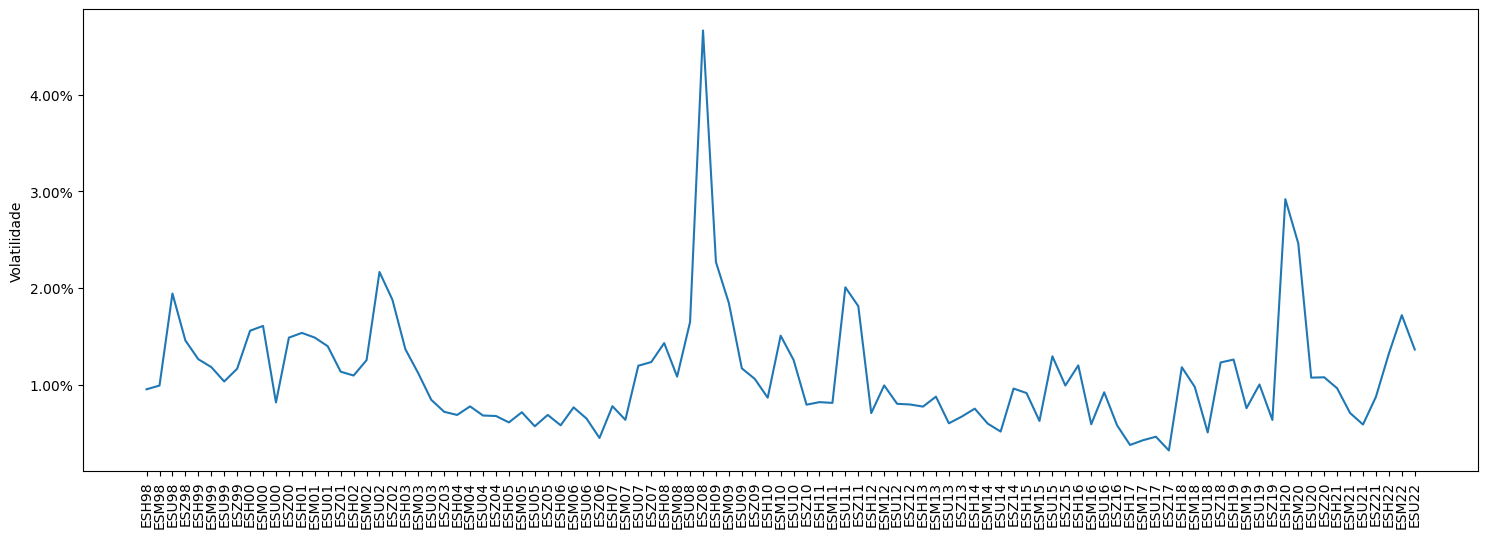

In [41]:
#Plot Vol Deltas
fig, ax = plt.subplots(figsize=(18, 6))
fig.gca().yaxis.set_major_formatter(mtick.StrMethodFormatter(fmt))
ax.tick_params(axis='x', labelrotation=90)
ax.set_ylabel("Volatilidade")
ax.set_xlabel(" ")

seaborn.lineplot(data=vols, x="0", y="Vol")


<Axes: xlabel=' ', ylabel='Delta Volatilidade'>

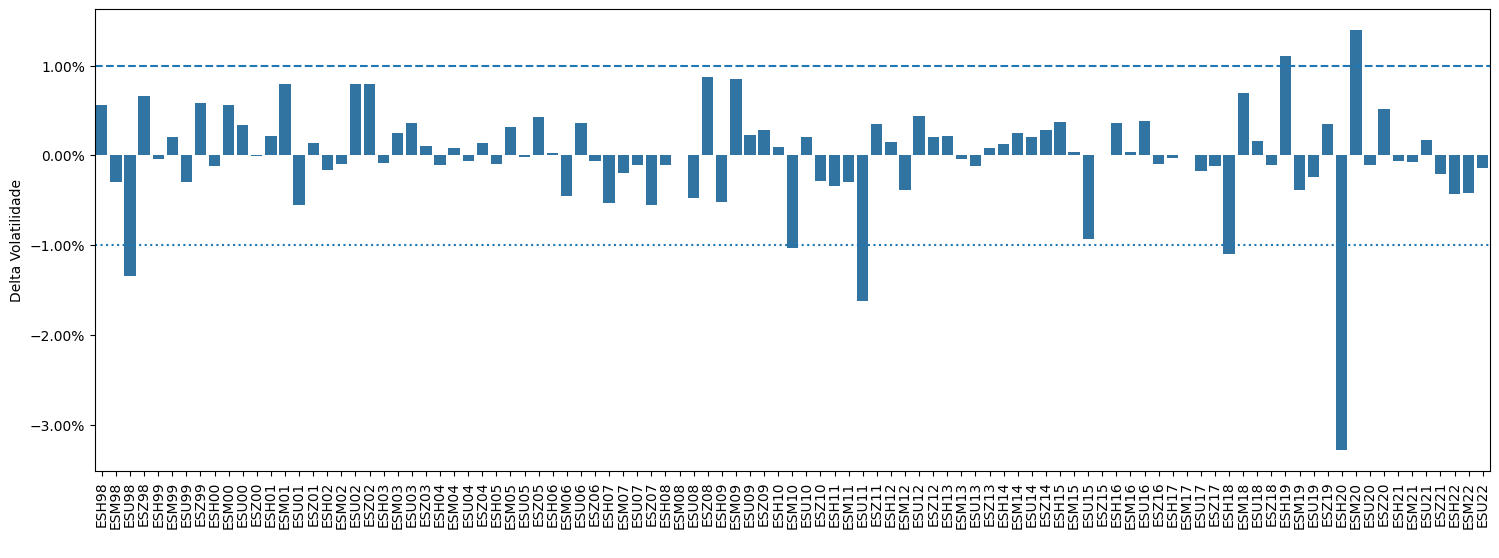

In [42]:
#Plot Vol Deltas
fig, ax = plt.subplots(figsize=(18, 6))
fig.gca().yaxis.set_major_formatter(mtick.StrMethodFormatter(fmt))
ax.tick_params(axis='x', labelrotation=90)
ax.set_ylabel("Delta Volatilidade")
ax.set_xlabel(" ")
ax.axhline(y=0.01, linestyle="--")
ax.axhline(y=-0.01, linestyle=":")
seaborn.barplot(data=volDeltas, x="0", y="Vol")


In [46]:
fig.savefig("../vol_changes.eps")

In [43]:
#How high needs to be volatility for it to be singificant. My benchmark: JNJ

dfJNJ = pd.read_csv(r"https://query1.finance.yahoo.com/v7/finance/download/JNJ?period1=1686135888&period2=1717758288&interval=1d&events=history&includeAdjustedClose=true")


In [44]:
dfJNJ["logReturns"] = (dfJNJ["Adj Close"]/dfJNJ["Adj Close"].shift(1)).apply(math.log)
dfJNJ = dfJNJ.drop(0)
dfJNJ["logReturns"]

1      0.010917
2     -0.001561
3     -0.000688
4      0.005240
5      0.005088
         ...   
247    0.009522
248    0.007269
249    0.000406
250   -0.012459
251    0.003078
Name: logReturns, Length: 251, dtype: float64

In [45]:
print("{:.4%}".format(dfJNJ["logReturns"].std()))

1.0179%


# Fligner test

In [65]:
flignerResults = [(a, flignerDFs(b)) for (a,b) in dframes]

In [69]:
flignerResults[0:10]

[('ESH98', 0.022967300196567363),
 ('ESM98', 0.26630390590378206),
 ('ESU98', 0.027556191343316952),
 ('ESZ98', 0.024965999802930607),
 ('ESH99', 0.7982754803221803),
 ('ESM99', 0.29170254253118577),
 ('ESU99', 0.2564903695948488),
 ('ESZ99', 0.024806224805990436),
 ('ESH00', 0.3766025245093443),
 ('ESM00', 0.44469510232171916)]

<Axes: xlabel=' ', ylabel='P-value Fligner > 0.1'>

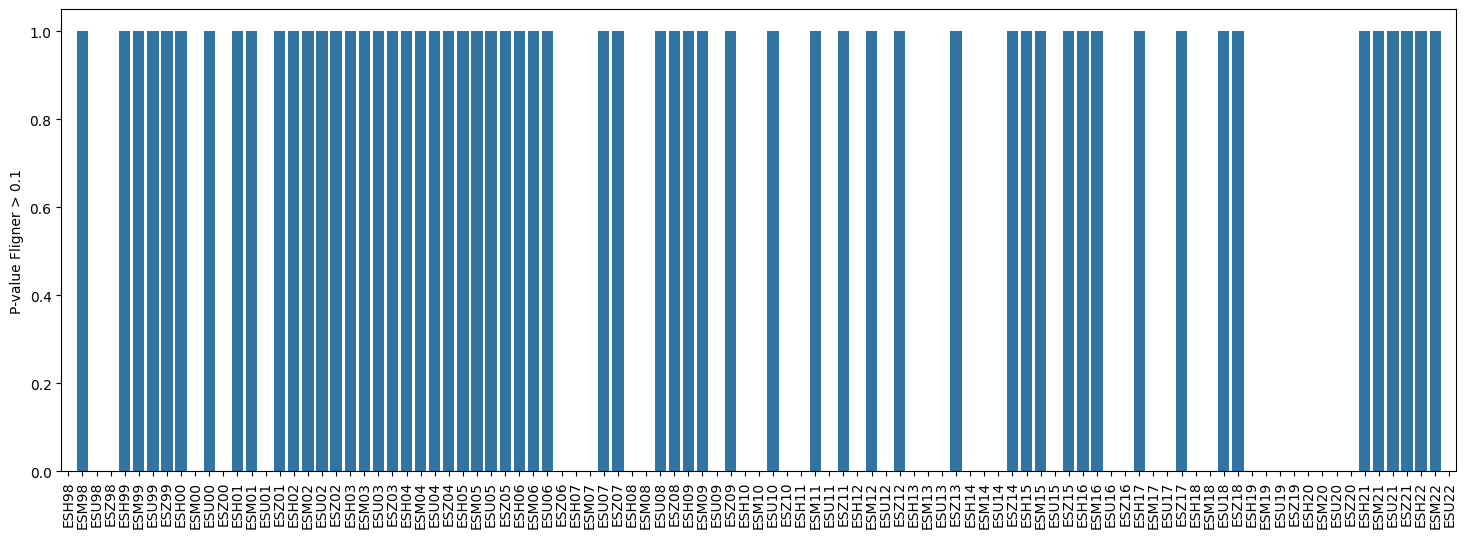

In [86]:
passedFligner = pd.DataFrame([(x ,1*(p>0.1)) for (x,p) in flignerResults], columns=["0","1"])


fig, ax = plt.subplots(figsize=(18, 6))
ax.tick_params(axis='x', labelrotation=90)
ax.set_ylabel("P-value Fligner > 0.1")
ax.set_xlabel(" ")

seaborn.barplot(x="0", y="1", data=passes)

In [76]:
fig.savefig("../fligner.eps")

In [83]:
set([a[:-5] for (a,b) in testResults if b > 0.1]).symmetric_difference(set([a for (a,b) in flignerResults if b > 0.1]))

{'ESH07',
 'ESH08',
 'ESH10',
 'ESH12',
 'ESH13',
 'ESH14',
 'ESH15',
 'ESH16',
 'ESH22',
 'ESM00',
 'ESM01',
 'ESM05',
 'ESM06',
 'ESM07',
 'ESM08',
 'ESM09',
 'ESM11',
 'ESM12',
 'ESM13',
 'ESM14',
 'ESM17',
 'ESU00',
 'ESU01',
 'ESU02',
 'ESU03',
 'ESU06',
 'ESU09',
 'ESU13',
 'ESU14',
 'ESU16',
 'ESU17',
 'ESU19',
 'ESU20',
 'ESU22',
 'ESZ00',
 'ESZ02',
 'ESZ05',
 'ESZ06',
 'ESZ07',
 'ESZ10',
 'ESZ14',
 'ESZ16',
 'ESZ17',
 'ESZ99'}

In [90]:
len(passedFligner[passedFligner["1"]==1])-99

-35